# Plotting og numerikk for labrapport

## Introduksjon

Vi har en U-formet bane og en kule, og ønsker å måle energitapsraten til kula i det den oscillerer i banen. Etter dette skal vi beregne hva luftmotstandskoeffisienten, $k$, for kula er.

## Oppsett og innstillinger

In [1]:
# Importer og sett opp moduler.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

plt.rcParams.update({'text.usetex': True,
                     'text.latex.preamble': r'\usepackage[cm]{sfmath}',
                     'font.size': 10,
                     'figure.figsize': (3.7,2.4),
                     'figure.autolayout': True,
                     'axes.grid': False,
                     'axes.linewidth': 0.4,
                     'lines.linewidth': 0.4,
                     'legend.frameon': False,
                     'legend.handlelength': 0.8,
                     'xtick.top': True,
                     'ytick.right': True,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.width': 0.2,
                     'ytick.major.width': 0.2})

In [2]:
# Definer konstaner.
M = 0.03   # Massen til kulen (kg).
G = 9.806  # Tyngdekraft (m/s²).

## Hjelpefunksjoner

In [3]:
import numpy.polynomial.polynomial as poly


def polyfit(data_set):
    """
    Finner et 15-grads-interpolasjonspolynom for et sett måledata,
    dvs. en polynomtilnærming til U-banen.

    :param data_set: DataFrame med data som skal interpoleres.
    :return: Liste med polynomkoeffisienter i stigende rekkefølge, [c0, c1, ...].
    """
    return poly.polyfit(data_set['x'].values, data_set['y'].values, 15)


def track_values(x, c):
    """
    Finn funksjonsverdi, derivert, andrederivert, stigningsvinkel, og krumningsradius
    for en gitt x-verdi, for et polynom.

    :param x: x-verdi.
    :param c: Koeffisienter til polynom i stigende rekkefølge, [c0, c1, ...].
    :return: (funksjonsverdi, derivert, andrederivert, stigningsvinkel, krumningsradius).
    """
    y = poly.polyval(x, c)
    dp = poly.polyder(c)
    dydx = poly.polyval(x, dp)
    ddp = poly.polyder(dp)
    d2ydx2 = poly.polyval(x, ddp)
    alpha = np.arctan(-dydx)
    r = (1 + dydx ** 2) ** 1.5 / d2ydx2
    return y, dydx, d2ydx2, alpha, r

In [4]:
def calculate_energy(data_set):
    """
    Regner ut energi for et sett data.
    
    :param data_set: DataFrame med data.
    :return: DataFrame med ekstra kolonner K (kinetisk energi), P (potensiell energi),
    og E (total mekanisk energi).
    """
    
    # Kinetisk energi (translasjon og rotasjon) i mJ.
    data_set['K'] = 0.7 * M * data_set['v']**2 * 1000

    # Potensiell energi i mJ.
    data_set['P'] = M * G * data_set['y'] * 1000

    # Mekanisk energi (= kinetisk + potensiell).
    data_set['E'] = data_set['K'] + data_set['P']
        
    return data_set


def calculate_forces(data_set):
    """
    Regner ut normalkraft og friksjonskraft (mN) for et sett data.
    
    :param data_set: DataFrame med data.
    :return: DataFrame med ekstra kolonner N (normalkraft) og f (friksjonskraft).
    """
    data_set['N'] = (M * G * np.cos(data_set['alpha']) + M * data_set['v']**2 / data_set['R']) * 1000
    data_set['f'] = (M * G * np.sin(data_set['alpha']) - M * data_set['a']) * 1000
    return data_set

## Innlesing av data eksportert fra Tracker

In [5]:
import glob


def read_data_from_csv(filename):
    """
    Les inn data fra csv-fil.

    :param filename: Sti til csv-fil.
    :return: DataFrame med kolonner t, x, y, v (og x- og y-retning), a, P (potensiell energi),
    K (kinetisk energi), E (total mekanisk energi), alpha (stigningsvnkel), R (krumningsradius),
    N (normalkraft), og f (friksjonskraft).
    """
    data_set = pd.read_csv(filename)

    # Konverter cm til m.
    data_set['x'] = data_set['x'] / 100
    data_set['y'] = data_set['y'] / 100
    data_set['v'] = data_set['v'] / 100
    data_set['a'] = data_set['a'] / 100

    # Forskyv y-verdiene sånn at den laveste målte verdien regnes som 0.
    min_y = min(data_set['y'])
    data_set['y'] = data_set['y'] - min_y

    # Fjern alle rader med NaN-verdier og (potensielt) fiks indeksene.
    data_set = data_set.dropna().reset_index(drop=True)
    
    # Forskyv t-verdiene sånn at den første verdien blir 0
    data_set['t'] = data_set['t'] - data_set['t'][0]

    # Finn stigningsvinkel og krumningsradius.
    c = polyfit(data_set)
    data_set['alpha'] = track_values(data_set['x'], c)[3]
    data_set['R'] = track_values(data_set['x'], c)[4]
    
    # 'Fjern' sentripetalakselerasjonen fordi vi ikke har bruk for den.
    data_set['a'] = data_set['a'] * np.sin(data_set['alpha'])
    
    data_set = calculate_energy(data_set)
    return calculate_forces(data_set)


def read_all_csv_files(data_dir='data/'):
    """
    Leser alle csv-filer i gitt mappe.

    :param data_dir: Mappe med csv-filer.
    :return: Liste med tupler (filnavn, dataframe).
    """
    filenames = glob.glob(data_dir + '*.csv')
    return [read_data_from_csv(filename) for filename in sorted(filenames)]

In [6]:
data_sets = read_all_csv_files()

## Numerikk

Vi antar et lineært forhold mellom friksjonskraften og farten til kula.
Den dynamiske ligningen til systemet, ved Newtons 2. lov, er da

\begin{equation}
    m \frac{\mathrm{d}^2 x}{\mathrm{d} t^2} = mg \sin \alpha(x) - f - k \frac{\mathrm{d} x}{\mathrm{d} t},
\end{equation}

der friksjonen grunnet underlaget, $f = \frac{2}{5} m~\mathrm{d}^2 x / \mathrm{d}t^2$.
Ved å innføre $v = \mathrm{d} x / \mathrm{d} t$ kan vi skrive om denne ligningen til to førsteordens diff.ligninger:

\begin{align}
    &\frac{\mathrm{d} x}{\mathrm{d} t} = v,\\
    &\frac{\mathrm{d} v}{\mathrm{d} t} = g \sin \alpha(x) - \frac{f + kv}{m}.
\end{align}

Dette settet kan løses numerisk med Eulers metode, $\mathbf{y}_{n+1} = \mathbf{y}_{n} + h \mathbf{f}(t_{n}, \mathbf{y}_{n})$, der

\begin{equation}
    h \text{ er steglengden}, \quad %
    \mathbf{y}_n = (x_n, v_n), \quad %
    \mathbf{f}(t_{n}, \mathbf{y}_{n}) = \left(v_n, g \sin \alpha(x) - \frac{f + k v_n}{m}\right).
\end{equation}

Vi får

\begin{align}
    &x_{n+1} = x_n + hv_n \cos \alpha(x),\\
    &v_{n+1} = v_n + h (g \sin \alpha(x) - \frac{2}{5} a - \frac{kv_n}{m}).
\end{align}

Luftmotstandskoeffisienten er gitt ved

\begin{equation}
    k = \frac{\Delta W}{Q}, \quad Q = \int_{t_1}^{t_2} v(t)^2 \mathrm{d}t.
\end{equation}

Vi bruker trapesmetoden til å tilnærme verdien av dette integralet.

Vi får bruk for stigningsvinkelen, $\alpha$, luftmotstandskoeffisienten, $k$, og akselerasjonen, $a$, i Eulers metode. Disse tilnærmer vi ved hjelp av måledata fra den eksperimentelle delen av forsøket.

In [7]:
def approx_drag_coefficient(data_set):
    """
    Tilnærmer luftmotstandskoeffisienten ut i fra måledata, ved bruk av trapesmetoden.
    
    :param data_set: DataFrame med måledata fra den eksperimentelle delen av forsøket.
    :return: Tilnærmeelse til Luftmotstandskoeffisienten.
    """
    
    # (Gjør om mJ til J.)
    delta_W = (data_set['E'][0] - data_set['E'].iat[-1]) / 1000
    
    # Trapesmetoden for å finne numerisk løsning av Q.
    a, b = data_set['t'][0], data_set['t'].iat[-1]
    N = len(data_set.index)
    h = (b - a)/(N - 1)
    Q = (h/2) * np.sum(data_set['v'].iloc[1:]**2 + data_set['v'].iloc[:-1]**2)
    
    return delta_W / Q

# Tar gjennomsnittet av alle k-tilnærmingene for alle settene med måledata.
ks = [approx_drag_coefficient(data_set) for data_set in data_sets]
k = sum(ks) / len(ks)
standard_error = np.sqrt(sum((val - k)**2 for val in ks) / (len(ks) - 1)) / np.sqrt(len(ks))
print('k-verdier:')
print(*ks, sep='\n')
print(f'\nk = {k}\nStandardfeil = {standard_error}')

k-verdier:
0.0033260516598542737
0.003277504099918992
0.003381815590938904
0.003627120087002922
0.0034068783479710503
0.003626845112388995
0.0033691478663744946
0.003969037295323382
0.0031989790171206467
0.003457237234731753
0.0036071411851972025
0.003408891039661287
0.003179555996987576

k = 0.003448938810267037
Standardfeil = 5.952707026962793e-05


Vi tar utgangspunkt i den første posisjonsmålingen i settet med måledata for å velge initialbetingelser for Eulers metode. Dette gjør det enklere å sammenligne den numeriske løsningen med den eksperimentelle.

In [8]:
def euler(data_set, N=10000, h=0.001):
    """
    Anvend Eulers metode på den dynamiske ligningen til systemet.

    :param data_set: DataFrame med måledata fra den eksperimentelle delen av forsøket.
    :return: Numerisk løsning av systemet i form av DataFrame med kolonner t, x, y, v, a,
    P (potensiell energi), K (kinetisk energi), E (mekanisk energi), alpha (stigningsvnkel),
    R (krumningsradius), N (normalkraft), f (friksjonskraft).
    """
    t, x, v = np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1)
        
    # Initialverdiene for tid, x, og fart settes på grunnlag av måledataene
    # for å forenkle sammenligning mellom numeriske løsninger og eksperimentelle.
    t[0], x[0], v[0] = data_set['t'][0], data_set['x'][0], data_set['v'][0]
    
    # Polynomkoeffisientene til polynomet som interpolerer måledataene.
    c = polyfit(data_set)
    
    # Initialverdiene for y, alpha, R, og a regnes ut.
    y, a, alpha, R = np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1)
    y[0], _, _, alpha[0], R[0] = track_values(x[0], c)
    a[0] = 5/7 * (G*np.sin(alpha[0]) - k*v[0]/M)
    
    for n in range(N):
        t[n + 1] = t[n] + h
        x[n + 1] = x[n] + h*v[n]*np.cos(alpha[n])
        
        # Verdier tilnærmet ved hjelp av interpolasjonspolynom.
        y[n + 1], _, _, alpha[n + 1], R[n + 1] = track_values(x[n + 1], c)
        
        # k har vi tilnærmet lengre oppe.
        a[n + 1] = 5/7 * (G*np.sin(alpha[n + 1]) - k*v[n]/M)
                
        v[n + 1] = v[n] + h * a[n + 1]

    # Returner en DataFrame med alle mulige kolonner.
    # Fart lagres i absoluttverdi (som måledataene).
    data_set = pd.DataFrame(data={'t': t, 'x': x, 'y': y, 'v': v, 'a': a, 'alpha': alpha, 'R': R})
    data_set['y'] = data_set['y'] - min(data_set['y'])
    data_set['v'] = np.abs(data_set['v'])
    return calculate_forces(calculate_energy(data_set))

## Visualisering/plotting

In [9]:
# Figurstørrelser.
large = (3.7, 2.4)   # Fyller hele kolonnen med tekst.
small = (1.95, 1.8)  # Fyller halve kolonnen med tekst (plass til to i bredden).

In [10]:
data_set = data_sets[2]
N = 1000000
h = 0.00001
euler_data_set = euler(data_set, N, h)

/home/olafal/Schoolwork/tfy4125/venv/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


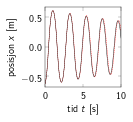

In [11]:
ax = data_set.plot(x='t', y='x', c='red', style='--', legend=None, figsize=small)
euler_data_set.plot(x='t', y='x', c='black', legend=None, ax=ax)
plt.xlabel('tid $t$ [s]')
plt.ylabel('posisjon $x$ [m]')
plt.savefig('x_tid.pdf', bbox_inches='tight', pad_inches=0.02)

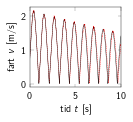

In [12]:
ax = data_set.plot(x='t', y='v', c='red', style='--', legend=None, figsize=small)
euler_data_set.plot(x='t', y='v', c='black', legend=None, ax=ax)
plt.xlabel('tid $t$ [s]')
plt.ylabel('fart $v$ [m/s]')
plt.savefig('fart_tid.pdf', bbox_inches='tight', pad_inches=0.02)

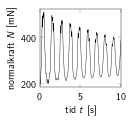

In [13]:
euler_data_set.plot(x='t', y='N', c='black', legend=None, figsize=small)
plt.xlabel('tid $t$ [s]')
plt.ylabel('normalkraft $N$ [mN]')
plt.savefig('normalkraft_tid_numerisk.pdf', bbox_inches='tight', pad_inches=0.02)

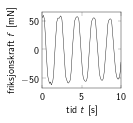

In [14]:
euler_data_set.plot(x='t', y='f', c='black', legend=None, figsize=small)
plt.xlabel('tid $t$ [s]')
plt.ylabel('friksjonskraft $f$ [mN]')
plt.savefig('friksjonskraft_tid_numerisk.pdf', bbox_inches='tight', pad_inches=0.02)

/home/olafal/Schoolwork/tfy4125/venv/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe2b7b70f98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/olafal/Schoolwork/tfy4125/venv/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


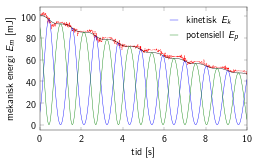

In [15]:
ax = data_set.plot(x='t', y='E', c='red', style='--', label='_nolegend_', legend=None, figsize=large)
euler_data_set.plot(x='t', y='E', c='black', label='_nolegend_', ax=ax)
euler_data_set.plot(x='t', y='K', c='blue', ax=ax)
euler_data_set.plot(x='t', y='P', c='green', ax=ax)
ax.legend(['kinetisk $E_k$', 'potensiell $E_p$'])
plt.xlabel('tid [s]')
plt.ylabel('mekanisk energi $E_m$ [mJ]')
plt.savefig('energi_tid.pdf', bbox_inches='tight', pad_inches=0.02)

/home/olafal/Schoolwork/tfy4125/venv/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


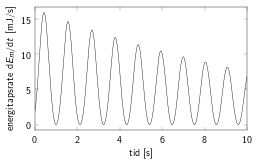

In [16]:
euler_data_set['dEdt'] = -euler_data_set['E'].diff() * 1/h  # Energitap per sekund. 
euler_data_set.plot(x='t', y='dEdt', c='black', legend=None, figsize=large)
plt.xlabel('tid [s]')
plt.ylabel('energitapsrate $\mathrm{d}E_m/\mathrm{d}t$ [mJ/s]')
plt.savefig('energitapsrate_tid_numerisk.pdf', bbox_inches='tight', pad_inches=0.02)

/home/olafal/Schoolwork/tfy4125/venv/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


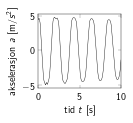

In [17]:
euler_data_set.plot(x='t', y='a', c='black', legend=None, figsize=small)
plt.xlabel('tid $t$ [s]')
plt.ylabel('akselerasjon $a$ [m/$s^2$]')
plt.savefig('akselerasjon_tid_numerisk.pdf', bbox_inches='tight', pad_inches=0.02)

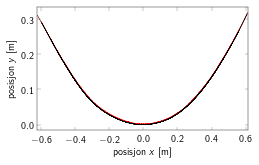

In [18]:
ax = data_set.plot(x='x', y='y', c='red', style='--', legend=None, figsize=large)
euler_data_set.plot(x='x', y='y', c='black', legend=None, ax=ax)
plt.xlabel('posisjon $x$ [m]')
plt.ylabel('posisjon $y$ [m]')
plt.savefig('x_y.pdf', bbox_inches='tight', pad_inches=0.02)